**Завдання:**

Використовуючи модель **ARIMA** і датасет **Yearly sunspots data 1700-2008** побудуйте прогноз на 2009-2030 р.р.

**1. Завантажимо та відобразимо зразок датасету.**

In [231]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import warnings
warnings.filterwarnings("ignore")

df = sm.datasets.sunspots.load_pandas().data

In [232]:
display(df.head())

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


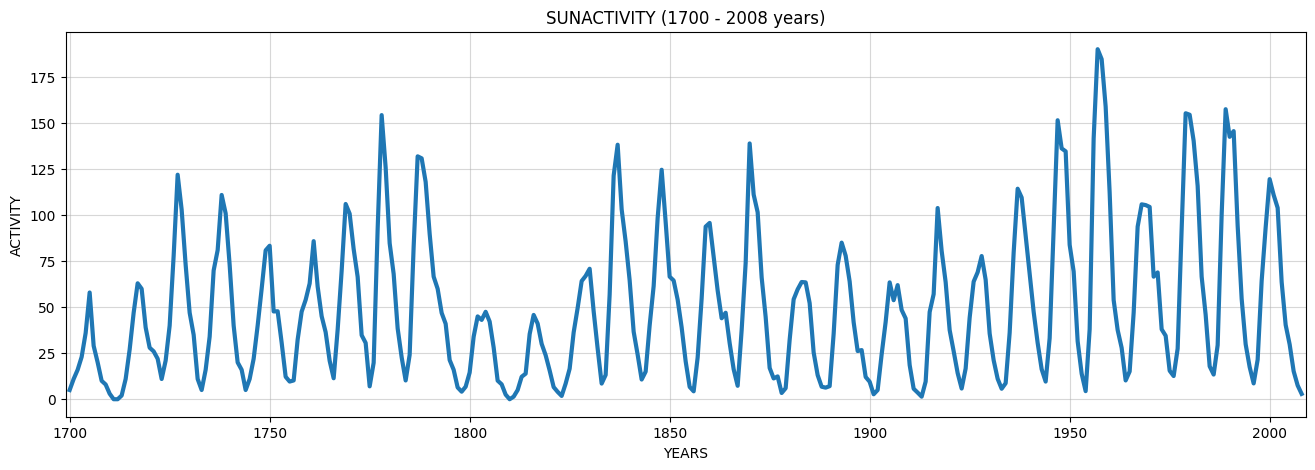

In [233]:
plt.figure(figsize=(16, 5))
plt.plot(df['YEAR'], df['SUNACTIVITY'], linewidth=3)
plt.title("SUNACTIVITY (1700 - 2008 years)")
plt.xlabel("YEARS")
plt.ylabel("ACTIVITY")
plt.grid(axis='x', alpha=0.5)
plt.grid(axis='y', alpha=0.5)
plt.xlim(1699, 2009)


plt.show()

Згідно даного графіку можна зробити висновок про циклічність сонячної активності та відсутність тренду. 
На мою думку, модель **ARIMA** не підходить для прогнозування даного часового ряду у зв'язку з циклічністю в 12 років, що необхідно враховувати у моделі. Для прогнозування даного часового ряду підійшла б модель **SARIMAX**.

**2. Зробимо відображення графіків ACF і PACF даного часового ряду.**

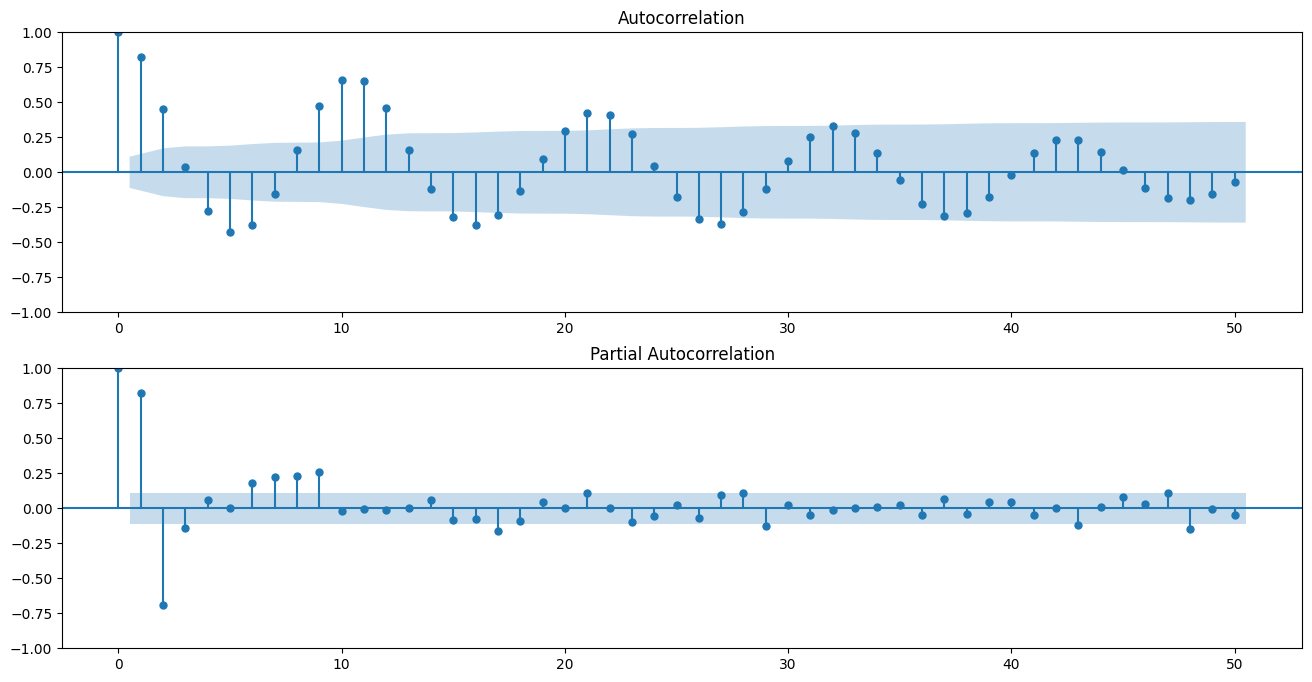

In [234]:

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['SUNACTIVITY'].values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['SUNACTIVITY'], lags=50, ax=ax2)

**Згідно даних гафіків можна зробити наступні висновки:**
1. Значення авторегресії **p** назначимо 13, згідно з максимальною кореляцією на перших 13 лагах графіку **ACF**.
2. Значення ковзаного середнього **q** назначимо 3, згідно зі значними кореляціями на перших 3 лагах графіку **PACF**.
3. Значення інтеграції **d** назначимо 0.


**3. Створимо модель ARIMA для даного часового ряда, та зробимо статистичний і графічний аналіз моделі.**

In [235]:
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')
df.set_index('YEAR', inplace=True)

In [236]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df[:-1], order=(13, 0, 3), trend='c')
arima_result = arima_model.fit()
print(arima_result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7654      7.342      6.778      0.000      35.376      64.155
ar.L1          0.3293      0.148      2.231      0.026       0.040       0.619
ar.L2          1.3398      0.132     10.121      0.000       1.080       1.599
ar.L3         -0.4689      0.150     -3.124      0.002      -0.763      -0.175
ar.L4         -0.7321      0.138     -5.301      0.000      -1.003      -0.461
ar.L5          0.5030      0.137      3.684      0.000       0.235       0.771
ar.L6         -0.0263      0.128     -0.206      0.837      -0.276       0.224
ar.L7          0.0070      0.133      0.053      0.958      -0.254       0.268
ar.L8          0.0222      0.131      0.170      0.865      -0.234       0.278
ar.L9          0.1190      0.138      0.864      0.388      -0.151       0.389
ar.L10         0.2650      0.103      2.581      0.0

З даної таблиці можна зробити висновок про низьке значення коефіцієнтів ar.L6 - ar.L9, ar.L11, ar.L13. Проте, у зв'язку з високим значенням коефіцієнта ar.L12, ми їх не будемо видаляти. На якість моделі не вплине видалення лише коефіцієнта ar.L13.

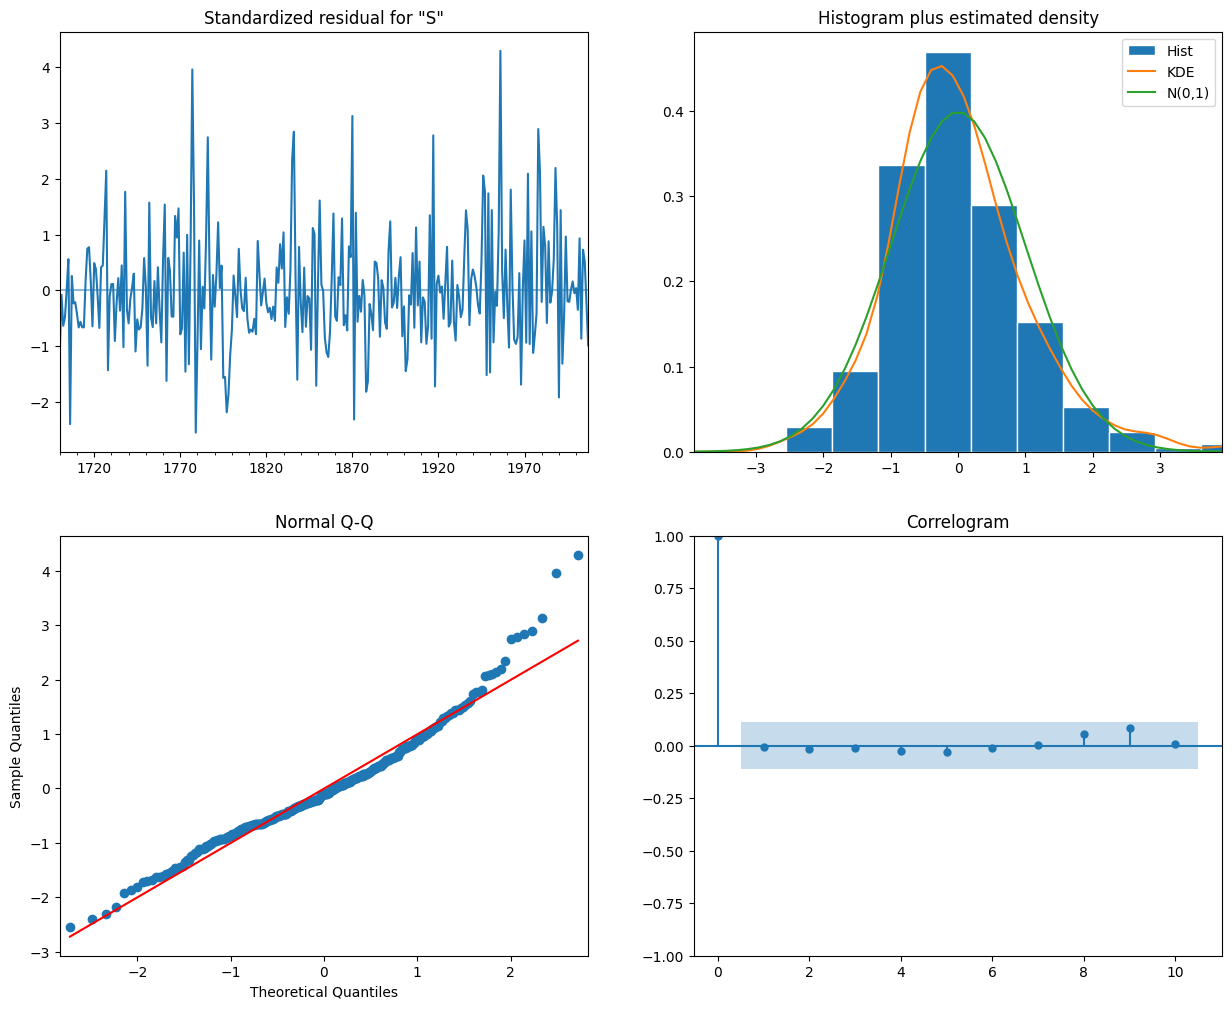

In [237]:
arima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

**Аналізуючі дані графіки можна зробити наступні висновки:**

1. Залишки моделі (різниця між реальними даними і даними, що прогнозуються) мають систематичний характер, який не враховується моделлю. Це підтвержує недоцільність використання моделі **ARIMA**.
2. Гістограма залишків має нормальний розподіл.
3. Підтвердження нормального росподілення залишків моделі по графіку **Normal Q-Q**.

**В результаті робимо висновок про досить якісний вибір показників авторегресії та ковзаного середнього, але не відповідність самої моделі ARIMA.**

**4. Зробимо статичний і динамічний прогнози даного часового ряду, використовуючи отриману модель ARIMA.**

In [215]:
arima_predict = arima_result.get_prediction(start=pd.to_datetime('1980'), dynamic=False)
arima_predict_ci = arima_predict.conf_int()

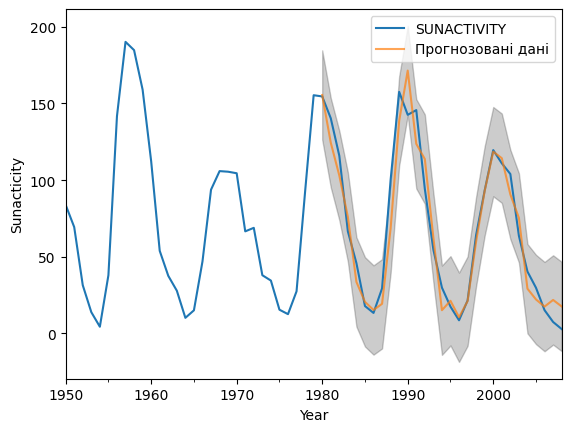

In [247]:
ax = df['1950':].plot(label='Відомі')
arima_predict.predicted_mean.plot(ax=ax, label='Прогнозовані дані', alpha=.7)
ax.fill_between(arima_predict_ci.index,
    arima_predict_ci.iloc[:, 0],
    arima_predict_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Sunacticity')
plt.legend()
plt.show()

In [245]:
y_forecasted = arima_predict.predicted_mean
y_truth = df['1980':]['SUNACTIVITY']
print('Середня похибка прогнозів = {}'.format(round(y_truth.sub(y_forecasted).mean(), 2)))

Середня похибка прогнозів = 1.83


In [240]:
arima_predict_dynamic = arima_result.get_prediction(start=pd.to_datetime('1980'), dynamic=True, full_results=True)
arima_predict_dynamic_ci = arima_predict_dynamic.conf_int()

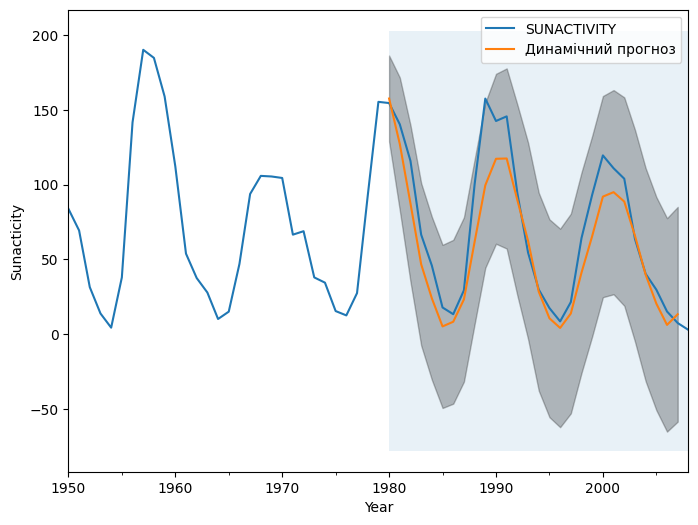

In [246]:
ax = df['1950':].plot(label='Відомі', figsize=(8, 6))
arima_predict_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(arima_predict_dynamic_ci.index,
    arima_predict_dynamic_ci.iloc[:, 0],
    arima_predict_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1980'), df.index[-1],
    alpha=.1, zorder=-1)
ax.set_xlabel('Year')
ax.set_ylabel('Sunacticity')
plt.legend()
plt.show()

Робимо висновок про досить посердню якість прогнозування, особливо при створенні динамічного прогнозу.

**5. Зробимо прогноз сонячної активності до 2030 року за допомогою отриманої моделі.**

In [242]:
pred_uc = arima_result.get_forecast(steps=21)
pred_ci = pred_uc.conf_int()

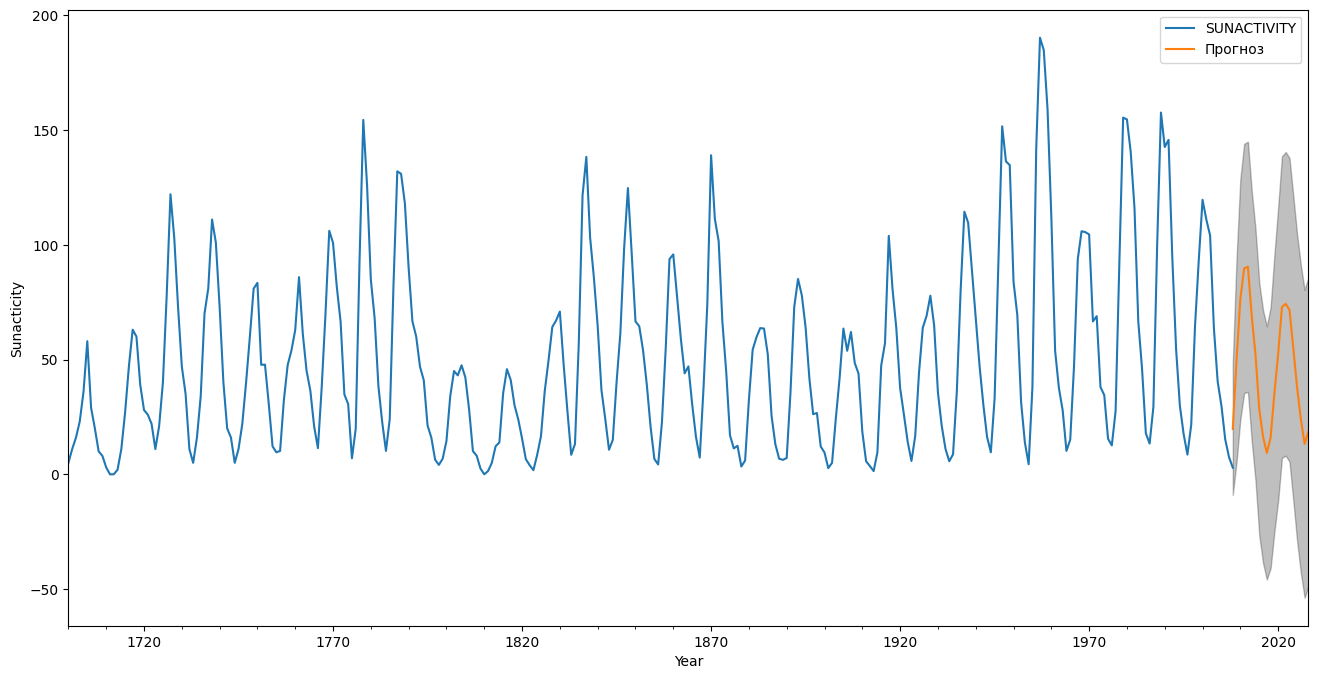

In [243]:
ax = df.plot(label='Відомі', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sunacticity')
plt.legend()
plt.show()